# Average superoperators for noisy gates

In ``SpinPulse``, we can calculate the channel superoperator $\mathcal{S}=\mathbb{E}[u^*\otimes u]$ representing the average quantum process associated with a quantum circuit.

This can be used to understand the effect of noise on the generation of quantum gates.

The purpose of the present notebook is to calculate $\mathcal{S}$ via the function ``mean_channel`` and represent the corresponding $\chi$ matrix graphically, for various types of gates and noise. This allows us in particular to benchmark ``SpinPulse`` with respect to analytical calculations.

## Idle qubits

We begin by considering single qubit in idle mode, i.e., only subject to Larmor frequency (qubit's frequency) noise, and consider the following parameters.

In [1]:
n_qb = 1
B0, delta, J_coupling = 0.1, 0.1, 0.005
ramp_dur = 0
T2S = 50
idle_duration = 25

We initialize a ``qiskit`` circuit with a single qubit forced to be idle during ``idle_duration``.

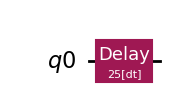

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister

delay_circ = QuantumCircuit(QuantumRegister(1))
delay_circ.delay(idle_duration)
delay_circ.draw("mpl")

We load an ``HardwareSpecs`` instance that we will use throughout this example.

In [3]:
from spin_pulse import HardwareSpecs, Shape

hardware_specs = HardwareSpecs(
    num_qubits=n_qb,
    B_field=B0,
    delta=delta,
    J_coupling=J_coupling,
    rotation_shape=Shape.SQUARE,
    ramp_duration=ramp_dur,
)

### Quasi-static noise

We begin with quasi-static noise and load the corresponding experimental environment. The ``segment_duration`` is used to keep the noise constant over the idle duration.

In [4]:
from spin_pulse import ExperimentalEnvironment
from spin_pulse.environment.noise import NoiseType

exp_env_quasistatic = ExperimentalEnvironment(
    hardware_specs=hardware_specs,
    noise_type=NoiseType.QUASISTATIC,
    T2S=T2S,
    duration=1000 * idle_duration,
    segment_duration=idle_duration,
)

The channel superoperator $\mathcal{S}$ is evaluated by averaging the matrix $u^*\otimes u$, over each circuit realization $u$, and for the duration of the experimental environment.

In [ ]:
from spin_pulse import PulseCircuit

pulse_circ_quasistatic = PulseCircuit.from_circuit(delay_circ, hardware_specs)
channel_quasistatic = pulse_circ_quasistatic.mean_channel(exp_env_quasistatic)

As described in our publication, the superoperator can be calculated analytically

$$
\mathcal{S}=\frac{1+C}{2}(\mathbf{1}\otimes \mathbf{1})
+\frac{1-C}{2}(Z\otimes Z)
$$

with Ramsey contrast $C=\exp\left(-t^2/(T_2^*)^2\right)$.

The function ``plot_chi_matrix`` represents the corresponding $\chi$ matrices, numerically and analytically calculated.

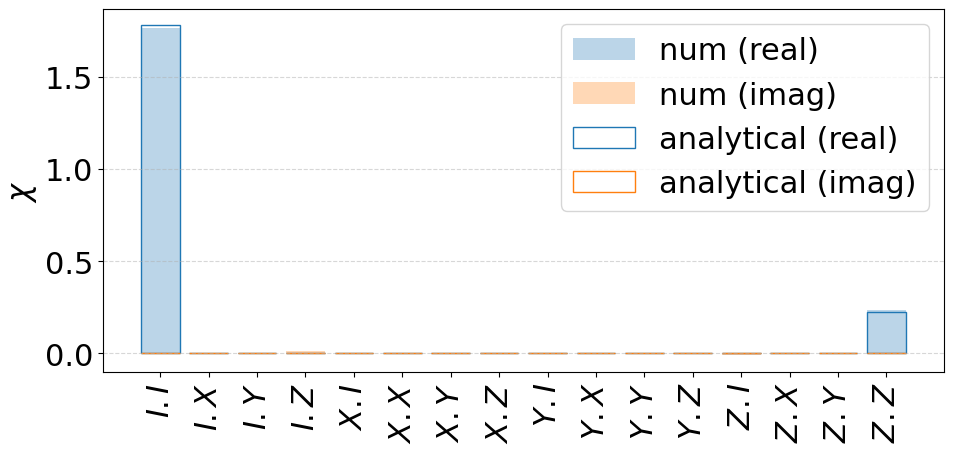

In [6]:
from spin_pulse.characterization.average_superop import (
    get_superop_from_paulidict,
    plot_chi_matrix,
)


def contrast_channel(C):
    return get_superop_from_paulidict({"II": (1 + C) / 2, "ZZ": (1 - C) / 2})


C_quasistatic = np.exp(-(idle_duration**2 / T2S**2))

fig = plot_chi_matrix(
    {"num": channel_quasistatic, "analytical": contrast_channel(C_quasistatic)}
)
# fig.savefig('../paper/fig4a.pdf',bbox_inches='tight')

### White noise

We proceed similarly with white noise, where analytical calculations predict a Ramsey contrast of the form $C(t)=\exp\left(-t/T_2^*\right)$.


  0%|                                                                                                                                    | 0/1000 [00:00<?, ?it/s]


 10%|████████████                                                                                                            | 101/1000 [00:00<00:00, 1009.31it/s]


 20%|████████████████████████▍                                                                                                | 202/1000 [00:00<00:01, 669.66it/s]


 28%|█████████████████████████████████▍                                                                                       | 276/1000 [00:00<00:01, 598.99it/s]


 34%|█████████████████████████████████████████▏                                                                               | 340/1000 [00:00<00:01, 588.79it/s]


 40%|████████████████████████████████████████████████▌                                                                        | 401/1000 [00:00<00:01, 567.18it/s]


 46%|███████████████████████████████████████████████████████▌                                                                 | 459/1000 [00:00<00:00, 560.60it/s]


 52%|███████████████████████████████████████████████████████████████                                                          | 521/1000 [00:00<00:00, 575.09it/s]


 58%|██████████████████████████████████████████████████████████████████████▎                                                  | 581/1000 [00:00<00:00, 580.33it/s]


 64%|█████████████████████████████████████████████████████████████████████████████▋                                           | 642/1000 [00:01<00:00, 588.87it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████                                    | 703/1000 [00:01<00:00, 592.53it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████▎                            | 763/1000 [00:01<00:00, 592.25it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 823/1000 [00:01<00:00, 591.85it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 883/1000 [00:01<00:00, 582.53it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 942/1000 [00:01<00:00, 578.86it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 594.73it/s]

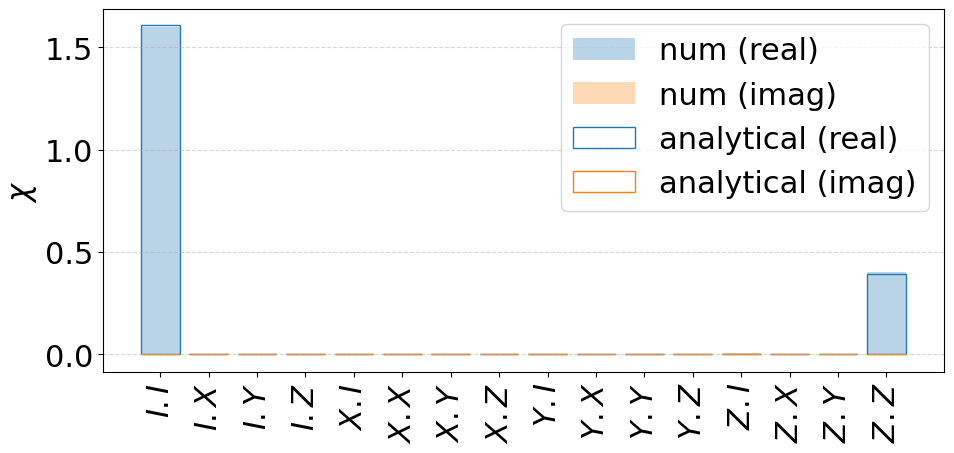

In [7]:
exp_env_white = ExperimentalEnvironment(
    hardware_specs=hardware_specs,
    noise_type=NoiseType.WHITE,
    T2S=T2S,
    duration=1000 * idle_duration,
    segment_duration=1,
)

pulse_circ_white = PulseCircuit.from_circuit(delay_circ, hardware_specs)
channel_white = pulse_circ_white.mean_channel(exp_env_white)

C_white = np.exp(-idle_duration / T2S)
fig = plot_chi_matrix({"num": channel_white, "analytical": contrast_channel(C_white)})
# fig.savefig('../paper/fig4b.pdf',bbox_inches='tight')

### Pink noise

Finally with pink noise, we obtain the superoperator.

In [ ]:
exp_env_pink = ExperimentalEnvironment(
    hardware_specs=hardware_specs,
    noise_type=NoiseType.PINK,
    T2S=T2S,
    duration=1000 * idle_duration,
    segment_duration=1000 * idle_duration,
)
pulse_circ_pink = PulseCircuit.from_circuit(delay_circ, hardware_specs)
channel_pink = pulse_circ_pink.mean_channel(exp_env_pink)

In this case, we have a Ramsey contrast $C(t)\approx \exp\left(-t^2/{T_2^*(t)}^2\right)$
with

$$
T_2^*(t) = T_2^*\sqrt{\frac{\log(1/(f_{\min}t))}{\log(1/f_{\min})}}
$$

where  $T_2^*$ is set by the parameter ``T2S``, and
$f_{\min} = (\text{segment\_duration})^{-1}$.

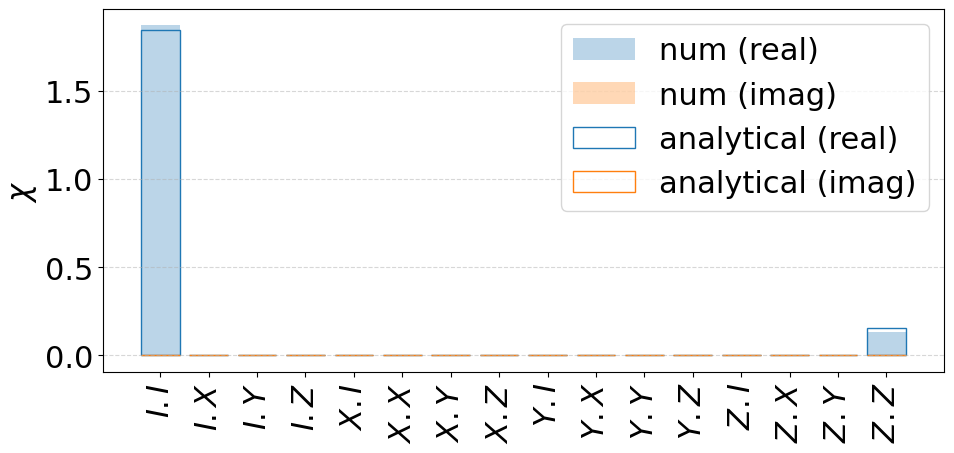

In [9]:
T2_t = T2S / np.sqrt(
    np.log(exp_env_pink.segment_duration / idle_duration)
    / np.log(exp_env_pink.segment_duration)
)

C_pink = np.exp(-(idle_duration**2) / (T2_t**2))
fig = plot_chi_matrix({"num": channel_pink, "analytical": contrast_channel(C_pink)})
# fig.savefig('../paper/fig4c.pdf',bbox_inches='tight')

## Single qubit $X$ Gate

Let us consider the effect of noise during application of a quantum gate, here $X=R_X(\pi)$ gate.


In [10]:
x_circ = QuantumCircuit(QuantumRegister(1))
x_circ.rx(np.pi, 0)

pulse_circ_x = PulseCircuit.from_circuit(x_circ, hardware_specs)

### Quasi-static noise

We first calculate numerically the superoperator describing the quantum process in presence of quasi-static noise.

In [ ]:
exp_env = ExperimentalEnvironment(
    hardware_specs=hardware_specs,
    noise_type=NoiseType.QUASISTATIC,
    T2S=T2S,
    duration=1000
    * pulse_circ_x.duration,  # we take the quasi-static duration to be exactly the circuit duration
    segment_duration=pulse_circ_x.duration,
)


channel_x_quasistatic = pulse_circ_x.mean_channel(exp_env)

Analytically, we can calculate the superoperator, in leading order in $\sigma=\sqrt{2}/T_2^*$, c.f., our publication.

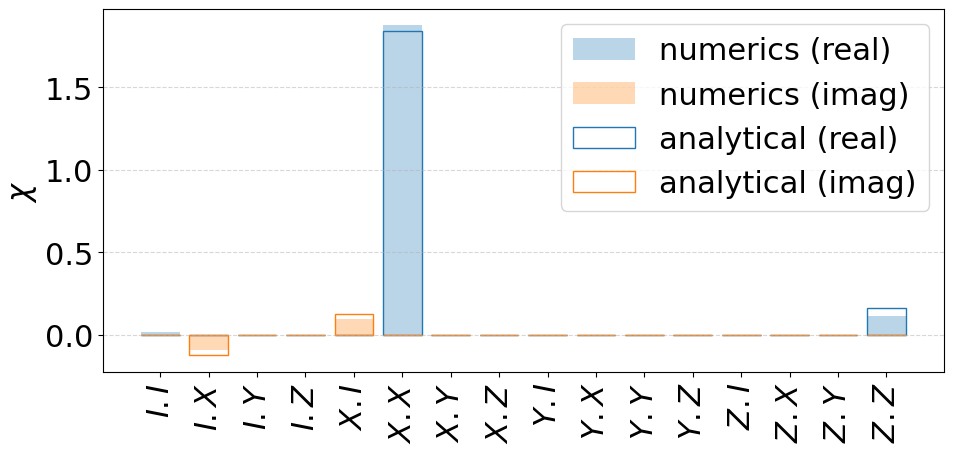

In [12]:
sigma = exp_env.time_traces[0].sigma
x_chan_pauli = {
    "XX": 1 - sigma**2 / B0**2,
    "IX": 1j * np.pi * sigma**2 / (4 * B0**2),
    "XI": -1j * np.pi * sigma**2 / (4 * B0**2),
    "ZZ": sigma**2 / B0**2,
}
channel_x_quasistatic_analytics = get_superop_from_paulidict(x_chan_pauli)
fig = plot_chi_matrix(
    {"numerics": channel_x_quasistatic, "analytical": channel_x_quasistatic_analytics}
)
# fig.savefig('../paper/fig4d.pdf',bbox_inches='tight')

### White noise

With white noise, we do not have an analytical expression for the superoperator.

In [ ]:
exp_env = ExperimentalEnvironment(
    hardware_specs=hardware_specs,
    noise_type=NoiseType.WHITE,
    T2S=T2S,
    duration=2**14,
    segment_duration=1,
)

pulse_circ_x = PulseCircuit.from_circuit(x_circ, hardware_specs)
channel_x_white = pulse_circ_x.mean_channel(exp_env)

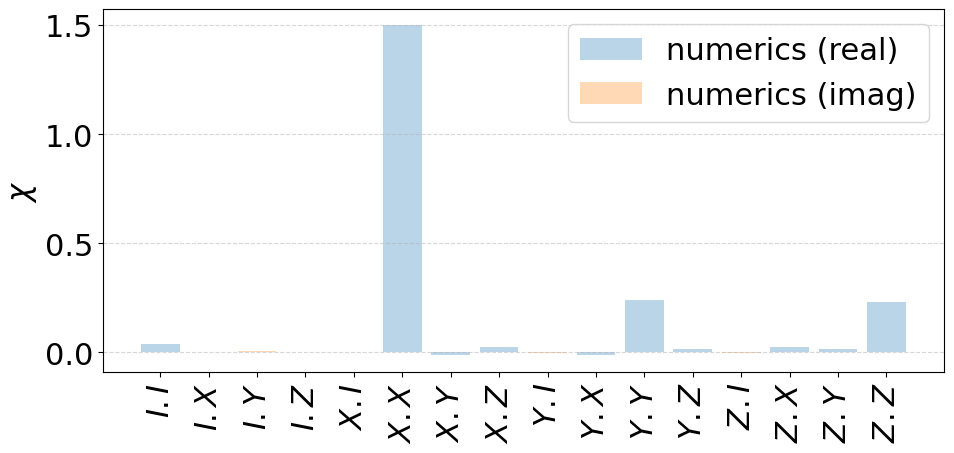

In [14]:
fig = plot_chi_matrix({"numerics": channel_x_white})
# fig.savefig('../paper/fig4e.pdf',bbox_inches='tight')

### Pink Noise

Finally, with pink noise, we realize that the superoperator has support on similar operators as for quasi-static noise.

In [15]:
exp_env = ExperimentalEnvironment(
    hardware_specs=hardware_specs,
    noise_type=NoiseType.PINK,
    T2S=T2S,
    duration=2**14,
    segment_duration=2**14,
)

pulse_circ_x = PulseCircuit.from_circuit(x_circ, hardware_specs)
channel_x_pink = pulse_circ_x.mean_channel(exp_env)


  0%|                                                                                                                                     | 0/528 [00:00<?, ?it/s]


  8%|█████████▊                                                                                                                 | 42/528 [00:00<00:01, 415.59it/s]


 16%|███████████████████▊                                                                                                       | 85/528 [00:00<00:01, 422.92it/s]


 24%|█████████████████████████████▌                                                                                            | 128/528 [00:00<00:00, 416.23it/s]


 33%|███████████████████████████████████████▋                                                                                  | 172/528 [00:00<00:00, 421.98it/s]


 41%|██████████████████████████████████████████████████▏                                                                       | 217/528 [00:00<00:00, 429.59it/s]


 49%|████████████████████████████████████████████████████████████                                                              | 260/528 [00:00<00:00, 423.56it/s]


 57%|██████████████████████████████████████████████████████████████████████                                                    | 303/528 [00:00<00:00, 423.44it/s]


 66%|███████████████████████████████████████████████████████████████████████████████▉                                          | 346/528 [00:00<00:00, 423.84it/s]


 74%|█████████████████████████████████████████████████████████████████████████████████████████▉                                | 389/528 [00:00<00:00, 420.20it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 432/528 [00:01<00:00, 393.70it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 472/528 [00:01<00:00, 329.54it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 510/528 [00:01<00:00, 340.89it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 528/528 [00:01<00:00, 386.57it/s]

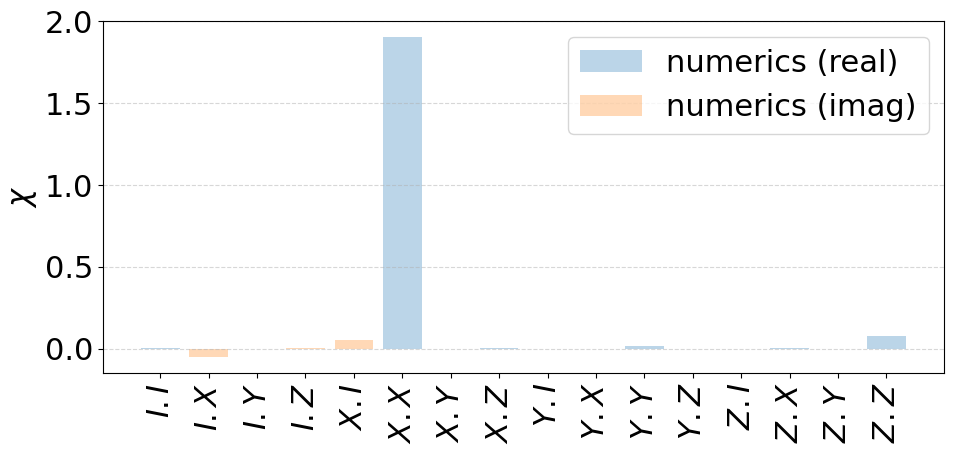

In [16]:
fig = plot_chi_matrix({"numerics": channel_x_pink})
# fig.savefig('../paper/fig4f.pdf',bbox_inches='tight')

<!-- Let us use a realization of full-drive DD (i.e. a $2n\pi$ X rotation over the idle period) to an idle qubit.

We start with an analytical example with quasi-static noise -->

## The two-qubit $R_{ZZ}$ gate under Larmor frequency (qubit's frequency) noise

Our analysis of the two qubit gate begins by redefining the parameters of the hardware, and the pulse circuit associated with an $R_{ZZ}(\pi/2)$ gate.

In [17]:
hardware_specs = HardwareSpecs(
    num_qubits=2,
    B_field=B0,
    delta=delta,
    J_coupling=J_coupling,
    rotation_shape=Shape.SQUARE,
    ramp_duration=ramp_dur,
)

circ_2q = QuantumCircuit(QuantumRegister(2))
circ_2q.rzz(np.pi / 2, 0, 1)
isa_circ_2q = hardware_specs.gate_transpile(circ_2q)

pulse_circ_2q = PulseCircuit.from_circuit(isa_circ_2q, hardware_specs)

We also define three experimental environments corresponding to quasi-static, white and pink noise. Compared to the single qubit case presented above, we increase the value of $T_2^*$, to obtain reasonable gate fidelities for the two qubit gate (which is here 10 times slower than the one qubit gate).

In [18]:
T2S = 1000

exp_env_coh = ExperimentalEnvironment(
    hardware_specs=hardware_specs,
    noise_type=NoiseType.QUASISTATIC,
    T2S=T2S,
    duration=1000 * pulse_circ_2q.duration,
    segment_duration=pulse_circ_2q.duration,
)

exp_env_white = ExperimentalEnvironment(
    hardware_specs=hardware_specs,
    noise_type=NoiseType.WHITE,
    T2S=T2S,
    duration=1000 * pulse_circ_2q.duration,
    segment_duration=1,
)

exp_env_pink = ExperimentalEnvironment(
    hardware_specs=hardware_specs,
    noise_type=NoiseType.PINK,
    T2S=T2S,
    duration=1000 * pulse_circ_2q.duration,
    segment_duration=1000 * pulse_circ_2q.duration,
)

We now define a function that calculates the relative superoperator $\mathcal{S}\mathcal{S_0}^\dagger$ to the ideal channel $S_0$ (corresponding to an ideal $R_{ZZ}$ gate). The graphical represenation of $\chi$ matrix of the relative superoperator will be easier to undertand. We also extract the fidelity directly from the superoperator.

In [19]:
from qiskit.quantum_info import Operator, SuperOp, average_gate_fidelity


def get_relative_channel(pulse_circ, exp_env):
    channel = pulse_circ.mean_channel(exp_env)
    relative_channel = channel.compose(SuperOp(pulse_circ.original_circ).adjoint())
    fidelity = average_gate_fidelity(channel, Operator(pulse_circ.original_circ))

    return relative_channel, fidelity

In [ ]:
channels = []
fidelities = []
for exp_env in [exp_env_coh, exp_env_white, exp_env_pink]:
    results = get_relative_channel(pulse_circ_2q, exp_env)
    channels.append(results[0])
    fidelities.append(results[1])
print("Fidelities ", fidelities)

As discussed in our publication, we can understand analytically the fact that the gate is much more robust against quasi-static, and pink noise, compared to white noise.
The relative superoperator can be expressed as

$$ \mathcal{S}S_0^\dagger
= \mathcal{S}_e\otimes \mathcal{S}_e $$

with

$$ \mathcal{S}_e=\frac{1+C_e}{2}(\mathbf{1}\otimes \mathbf{1})
+\frac{1-C_e}{2}(Z\otimes Z) $$

and $C_e$ is the Ramsey contrast associated with spin-echo (see publication).
We have $C_e(1)$ for quasi-static noise,

$$C_e(t)=\exp(-t/T_2^*)$$

for white noise. For pink noise, we do not have a analytical expression, but expect

$$C_e(t)\gg \exp(-t^2/(T_2^*)^2)$$

because our gates involve a spin echo sequence.

In [21]:
# White noise
# fig = plot_chi_matrix({"num": channels[0]}, threshold=1e-2)
# fig.savefig('../paper/fig4g.pdf',bbox_inches='tight')

Let us check this expression for white noise, defining the spin-echo Ramsey contrast and the corresponding relative channel

In [22]:
print(hardware_specs)

HardwareSpec:
num_qubits: 2
B_field: 0.1
delta: 0.1
J_coupling: 0.005
rotation_shape: Shape.SQUARE
ramp_duration: 0
coeff_duration: N/A
dynamical_decoupling: None


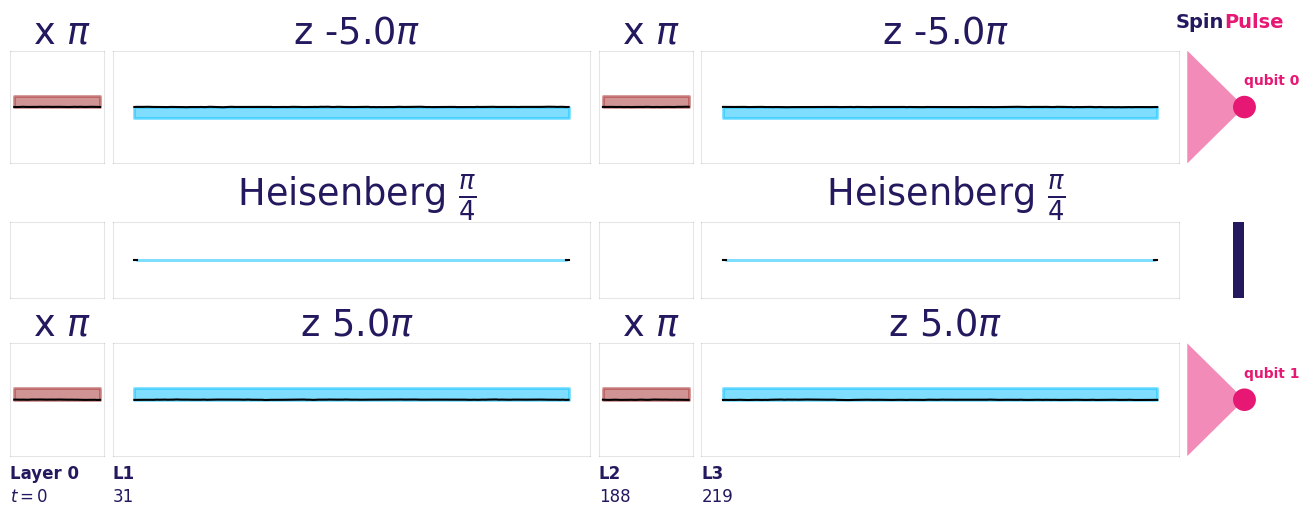

In [23]:
pulse_circ_2q.plot()

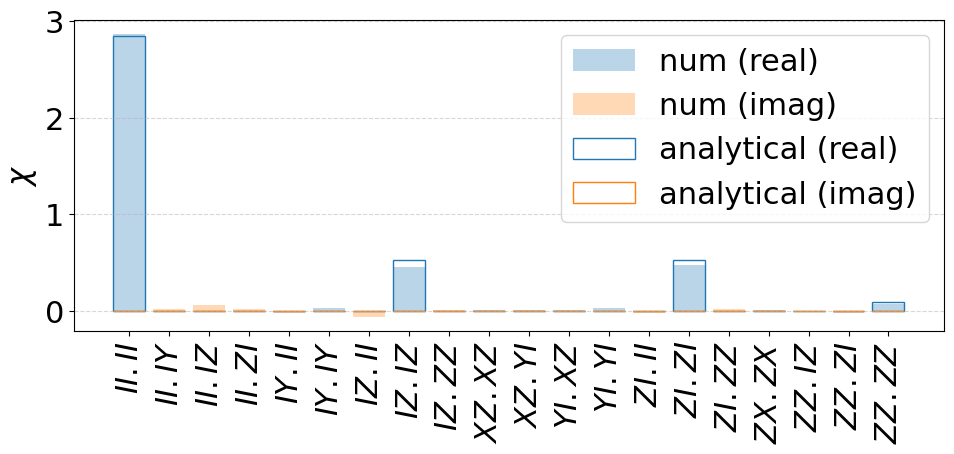

In [24]:
C_se = np.exp(-pulse_circ_2q.duration / T2S)
channel_white = contrast_channel(C_se).tensor(contrast_channel(C_se))

fig = plot_chi_matrix(
    {"num": channels[1], "analytical": channel_white},
    threshold=1e-2,
)
# fig.savefig('../paper/fig4h.pdf',bbox_inches='tight')

In [25]:
print("Numerical fidelity ", fidelities[1])
print("Analytical fidelity ", (1 + 4 * C_se) / 5)

Numerical fidelity  0.7730677827736923
Analytical fidelity  0.7492818664338408


In [26]:
# pink noise
# fig = plot_chi_matrix({"num": relative_channel_2q[2]}, threshold=1e-2)
# fig.savefig('../paper/fig4i.pdf',bbox_inches='tight')

## The two-qubit $R_{ZZ}$ gate under gate exchange noise

Finally we consider the effect of gate exchange noise, by setting the value of $T_J^*\ll T_2^*$, and compare the superoperator, with the one obtained analytically.

In [27]:
T2S = 1_000_000
TJS = 500

exp_env = ExperimentalEnvironment(
    hardware_specs=hardware_specs,
    noise_type=NoiseType.QUASISTATIC,
    T2S=T2S,
    duration=1000 * pulse_circ_2q.duration,
    segment_duration=pulse_circ_2q.duration,
    TJS=TJS,
)

In [ ]:
channel, fidelity = get_relative_channel(pulse_circ_2q, exp_env)

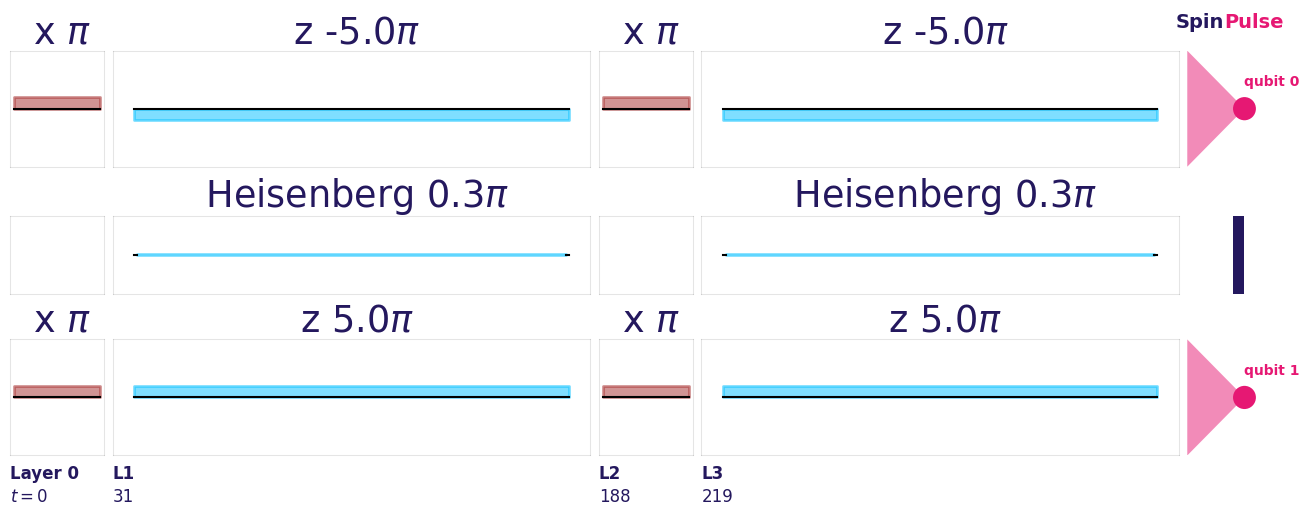

In [29]:
pulse_circ_2q.plot()

Fidelity  0.8719754450724861
Fidelity (analytics)  0.8913650513317535


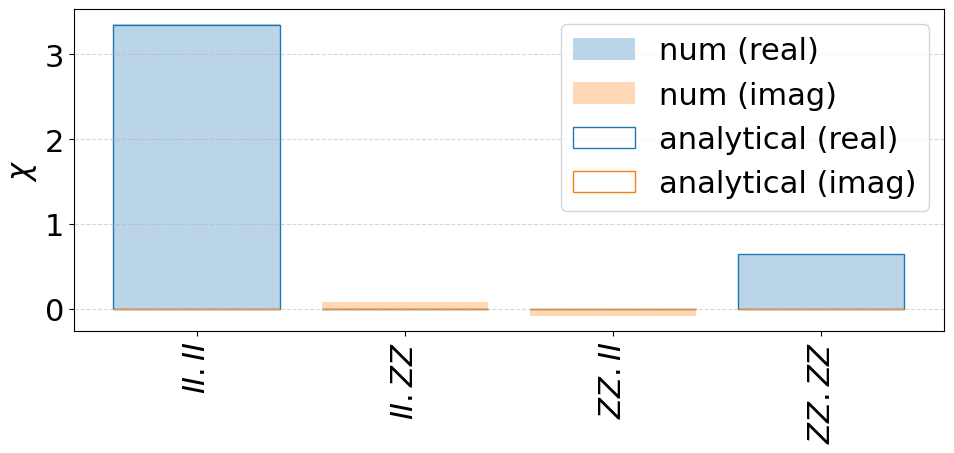

In [30]:
twoq_duration = (
    2
    * pulse_circ_2q.pulse_layers[1]
    .twoq_pulse_sequences[0]
    .pulse_instructions[1]
    .duration
)  # Duration of the two qubit gate

C = np.exp(-(twoq_duration**2) / TJS**2)

twoq_contrast_superop = get_superop_from_paulidict(
    {"IIII": (1 + C) / 2, "ZZZZ": (1 - C) / 2}
)
fig = plot_chi_matrix(
    {"num": channel, "analytical": twoq_contrast_superop}, threshold=1e-2
)

fidelity_analytics = (2 + C) / 3
print("Fidelity ", fidelity)
print("Fidelity (analytics) ", fidelity_analytics)